# Q-Learning Lab Notebook

In this notebook, you will learn the basics applying the Q-Learning algorithm to simple environments in OpenAI Gym.  By the end of the notebook, you will have a working Q-Learning agent that can balance a CartPole as well as solve other simple control problems in alternate environments.

## Sections

1. <a href=#rl>Basic concept of reinforcement learning (RL)</a>
- <a href=#cp>CartPole environment from OpenAI Gym</a>
- <a href=#random>CartPole with a random agent</a>
- <a href=#qlcode>Q-Learning Implementation in Python</a>
- <a href=#qlagent>CartPole with a Q-Learning agent</a>
- <a href=#mtn>MountainCar environment from OpenAI Gym</a>

## Requirements
* OpenAI Gym[classic_control] 0.7.4 or higher 
* Python 3.5 or higher
* CUDA8.0 enabled GPU

Portions of this notebook have been borrowed from the Nvidia Deep Learning Institute (DLI) hands-on labs.

# 1. Reinforcement learning <a name='rl' />

### Problem setting

Unlike standard supervised learning in machine learning, reinforcement learning is about sequential decision making of an agent, which takes actions to maximize cumulative reward, by interacting with environments (problems).

<img src="image/rl.png" width="200">

After observing the current state $s_t$ and reward $r_t$, agent will decide which action to take $a_t$.

For clarity, here we assume that actions are discrete, and reward is a scalar value. Multi-dimensional state $s_t$ can be either discrete or continuous.

### Action-value function approximation

There are multiple strategies in RL on how to represent the policy, the behavior mechanism inside the agent and how to optimize it.

In most of this hands-on session, we just consider action-value function approximation, in which the expected cumulative reward for all future steps is represented as a function $Q(s, a)$ for pairs of state $s$ and following action $a$.

By learning a good approximation of optimal action-value function $Q(s, a)$, by taking action $a_t$ which maximizes the learned Q-value $Q(s_t, a_t)$ given $s_t$ at each time step $t$, the optimal policy should be realized.

# 2. Example - CartPole <a name='cp' />

In this section, we introduce a control problem named CartPole and describe the way it is handled as a RL problem.  Before looking closer at the CartPole environment, we'll import the packages we need and define a visualization function.

### Preparation: Import packages

In [1]:
# install packages in Udacity Workspaces
# xvfb-run -s "-screen 0 1400x900x24" bash && export DISPLAY=:0
!python -m pip install pyvirtualdisplay

/usr/bin/python: No module named pip


In [2]:
# uncomment for Udacity server using xvfb
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [3]:
# The typical imports
import gym
import numpy as np
from tqdm import tqdm

# visualization helpers
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Set logger level
import logging
logging.basicConfig(level=logging.ERROR)

### CartPole Environment

As an example of classical RL problem, we use CartPole-v0 from [OpenAI Gym](https://gym.openai.com/), which contains two-dimensional physics simulator of a black cart and a yellow pole. It is a kind of inverted pendulum.

<img src="image/cartpole.png?" width="450">

The following overview of CartPole-v0 is taken from [Gym's Wiki page](https://github.com/openai/gym/wiki/CartPole-v0)

#### Description
By an un-actuated joint, a pole is attached to a cart, which moves along a frictionless track. The pendulum starts upright, and the goal is to prevent it from falling over by increasing and reducing the cart's velocity.

#### Observation
Type: Box(4)

Num | Observation | Min | Max
---|---|---|---
0 | Cart Position | -2.4 | 2.4
1 | Cart Velocity | -Inf | Inf
2 | Pole Angle | ~ -41.8&deg; | ~ 41.8&deg;
3 | Pole Velocity At Tip | -Inf | Inf

#### Actions
Type: Discrete(2)

Num | Action
--- | ---
0 | Push cart to the left
1 | Push cart to the right

Note: The amount the velocity is reduced or increased is not fixed as it depends on the angle the pole is pointing. This is because the center of gravity of the pole increases the amount of energy needed to move the cart underneath it

#### Conditions for episode termination 
1. Pole Angle is more than ±20.9°
2. Cart Position is more than ±2.4 (center of the cart reaches the edge of the display)
3. Episode length is greater than 200

#### Reward
Reward is 1 for every step taken, including the termination step

#### Starting state
All observations are assigned a uniform random value between ±0.05

### How Gym's environment works

Gym's environment (problem) has a unified interface with the following three steps.

#### 1. Create environment specified by name
```python
env = gym.make('ENV_NAME')
```
#### 2. Initialize environment

```python
env.reset()
```
#### 3. Take action and observe reward & next state
```python
observation, reward, is_finished, info = env.step(action)
```
where
  - obs: a next observation
  - reaward: a scalar reward
  - is_finished: a boolean value indicating whether the current state is terminal or not
  - info: additional information

By interacting the environment, a reinforcement learning agent learns how to optimize its strategy for maximizing cumulative reward.

### Execution: How the environment works

Create the CartPole environment and observe the initial state and the result of an action.  In this case a random action has been selected by sampling the action space.

In [4]:
# Create  environment of CartPole-v0
env = gym.make('CartPole-v0')
print('observation space:', env.observation_space)
print('action space:', env.action_space)

observation = env.reset()
# env.render(mode='rgb_array', close=True)
print('initial observation:', observation)

action = env.action_space.sample() # Select random action
print('random action:', action)
observation, reward, is_finished, info = env.step(action)
print('next observation:', observation)
print('reward:', reward)
print('is_finished:', is_finished)
print('info:', info)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
observation space: Box(4,)
action space: Discrete(2)
initial observation: [-0.01457592  0.04801101  0.01353517 -0.00053875]
random action: 0
next observation: [-0.0136157  -0.14730241  0.01352439  0.29638377]
reward: 1.0
is_finished: False
info: {}


# 3. CartPole with the Random agent <a name='random' />

### Class: Random agent

In [ ]:
# copied from gym examples - a model for our agent
class RandAgent(object):
    """The world's simplest agent!"""
    def __init__(self, action_space):
        self.action_space = action_space

    def act(self, observation, reward, done=None, mode=None):
        return self.action_space.sample()
    
    def init_episode(self, observation):
        # provided for compatibility with general learner
        return self.action_space.sample()


### Definition: Learner for agents

In [12]:
# This learner provides a general interface for agents and environments 
# optionally visualize within a Jupyter Notebook when visualize_plt is True
def learner(agent=None, env_id='CartPole-v0', episodes=100, max_length = 100, init_reward=0, 
            ignore_done=False, visualize_plt=True, mode=None):
    # load the environment 
    env = gym.make(env_id)
    # set the agent to random if none provided
    if agent is None:
        agent = RandAgent(env.action_space)

    # each episode runs until it is observed as finished, or exceeds max_length in time steps
    episode_count = episodes
    done = False
    n_steps = np.zeros((episode_count,))

    # run the episodes - use tqdm to track in the notebook
    for i in tqdm(range(episode_count), disable=visualize_plt):
        
        # Initialize environment for each episode
        ob = env.reset()  
        reward = init_reward
        if visualize_plt:
            img = plt.imshow(env.render(mode='rgb_array')) # only call this once, only for jupyter
        
        # initialize the agent
        agent.init_episode(ob)
        n_steps[i]=max_length
        
        # run the steps in each epsisode
        for t in range(max_length):
            # render the environment
            if visualize_plt:
                img.set_data(env.render(mode='rgb_array')) # just update the data
                plt.axis('off')
                display.display(plt.gcf())
                display.clear_output(wait=True)
            else:
                env.render()
            
            # get agent's action
            action = agent.act(ob, reward, mode=mode)
            # take the action and get reward and updated observation
            ob, reward, done, _ = env.step(action)
            
            # terminate the steps if the problem is done
            if done and not ignore_done:
                n_steps[i] = t
                break
            if done and ignore_done and env_id=='MountainCar-v0' and ob[0]>= 0.5:
                # special case MountainCar
                # if have achieved the goal, then quit but otherwise keep going
                print("Episode {} done at step {}".format(i,t))
                print("Observations {}, Reward {}".format(ob, reward))
                n_steps[i] = t
                break
    env.close()
    return n_steps  # stats

### Execution: Run the experiment with the random agent

Before introducing an RL agent, you can just repeat random actions to see how the environment changes over time. Here you repeat the episode for 10 times.  The number of steps before the cart fails are recorded for each episode.  

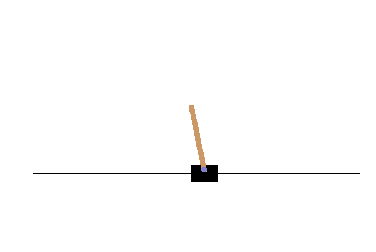

In [13]:
num_episodes = 10
max_length = 200
steps = learner(episodes=num_episodes, max_length=max_length)

In [14]:
print("Minimum step count in {} episodes: {}".format(num_episodes, np.min(steps)))
print("Average step count in {} episodes: {}".format(num_episodes, np.mean(steps)))
print("Maximum step count in {} episodes: {}".format(num_episodes, np.max(steps)))

Minimum step count in 10 episodes: 8.0
Average step count in 10 episodes: 16.5
Maximum step count in 10 episodes: 33.0


# 4. Traditional RL = Q-learning <a name='qlcode' />

Q-learning is one of the most popular approaches in reinforcement learning, to determine which action is optimal on each state.

At each time step $t$, after taking an action $a_t$ and given reward $r_{t+1}$ and next state $s_{t+1}$, the old Q-value $Q(s_t, a_t)$ is updated by the following rule. 

<img src="image/q-learning.svg" width="800">

It is not necessary to follow the details of math but the intuition is: the Q-value should be updated by taking into account the difference between the old value and the sum of the actual reward and the discounted estimated future value obtained by next action, by the factor of learning rate $\alpha_t$.

Q-learning is an iterative algorithm, so Q-values are used to take actions and then gradually improved over time.

To make the good balance between exploration (random action) and exploitation (estimated best action), $\epsilon$-greedy strategy is typically used with Q-learning in which where the agent take random actions with probability $\epsilon$  and current best action otherwise.

The simplest way to implement Q-Learning is to build a table, named Q-table, to store the Q-value for each discrete state and action combination.

### Class: Q-learning agent

Here we define the QLearningAgent class, in which the observation space is discretized into q-tables of size 20,000 =  ((that of bins (9)+1) ^ numbers of observations (4)) * number of actions (2). Each cell represents current Q-value for each combination of discretized state and possible action.

By calling the `act()` method with the current observation (and reward), the agent updates the Q-table and returns the next action.

The hyper-parameters for training have been set at default values, but may be modified when called:

**`learning_rate` = 0.2**
* the new information replaces 20% of the old information at each step

**`discount_factor` = 1.0** 
* the agent will strive for a long-term high reward because the value includes expected future rewards

**`exploration_rate` = 0.5**
* the agent will choose a random action, i.e. "explore", 50% of the time

**`exploration_decay_rate` = 0.99**
* the probability of exploration will be reduced by 1% at the start of each episode

In [15]:
class QLearningAgent:
    def __init__(self, 
                 learning_rate = 0.2, discount_factor = 1.0,
                 exploration_rate = 0.5, exploration_decay_rate = 0.99,
                 n_bins = 9, n_actions = 2, splits=None):
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate # initial epsilon
        self.exploration_decay_rate = exploration_decay_rate # decay factor for epsilon
        self.n_bins = n_bins
        self.n_actions = n_actions
        self.splits = splits
        self.state = None
        self.action = None
        
        if self.splits is None: #CartPole default
            self.splits = [
                # Position
                np.linspace(-2.4, 2.4, self.n_bins)[1:-1],
                # Velocity
                np.linspace(-3.5, 3.5, self.n_bins)[1:-1],
                # Angle.
                np.linspace(-0.5, 0.5, self.n_bins)[1:-1],
                # Tip velocity
                np.linspace(-2.0, 2.0, self.n_bins)[1:-1]
            ]
        
        # Create Q-Table
        num_states = (self.n_bins+1) ** len(self.splits)
        self.q_table = np.zeros(shape=(num_states, self.n_actions))

    # Turn the observation into integer state
    def set_state(self, observation):
        state = 0
        for i, column in enumerate(observation):
            state +=  np.digitize(x=column, bins=self.splits[i]) * ((self.n_bins + 1) ** i)
        return state

    # Initialize for each episode
    def init_episode(self, observation):
        # Gradually decrease exploration rate
        self.exploration_rate *= self.exploration_decay_rate

        # Decide initial action
        self.state = self.set_state(observation)
        return np.argmax(self.q_table[self.state])

    # Select action and update
    def act(self, observation, reward=None, done=None, mode='train'):
        next_state = self.set_state(observation)
        
        if mode == 'test':
            # Test mode 
            next_action = np.argmax(self.q_table[next_state])
        else:
            # Train mode by default
            # Train by updating Q-Table based on current reward and 'last' action.
            self.q_table[self.state, self.action] += self.learning_rate * \
                (reward + self.discount_factor * max(self.q_table[next_state, :]) - self.q_table[self.state, self.action])
            # Exploration or exploitation
            do_exploration = (1 - self.exploration_rate) < np.random.uniform(0, 1)
            if do_exploration:
                #  Exploration
                next_action = np.random.randint(0, self.n_actions)
            else:
                # Exploitation
                next_action = np.argmax(self.q_table[next_state])

        self.state = next_state
        self.action = next_action
        return next_action

# 5. CartPole with the Q-Learning agent <a name='qlagent' />

### Preparation: Initialize the Q-learning agent and training parameters

Beginning from an empty Q-table, QLearningAgent tries to learn $Q(s_t, a_t)$ by Q-learning with $\epsilon$-greedy strategy in 50 episodes. The result gif shows the agent gradually learns from trials and errors.

In [16]:
# Instantiate the agent
q_agent = QLearningAgent()

In [17]:
num_episodes = 50
max_length = 200
initial_reward = 1

### Execution: Train the Q-learning agent

Each time the learner cell is executed, the agent improves its policy.  To start over from scratch with the agent, go back and execute the cell that instantiates the agent with `q_agent = QLearningAgent()` 

The result statistics of average and maximum steps achieved during the episodes shows that over time the agent is able to improve its behavior.  We can see this in the visualization as the CartPole is able to stay verticle for longer periods of time after more training episodes.

In [18]:
# train the agent - execute this cell as many times as you wish
# set the visualize_plt flag to True to see the cart in the notebook.  
# note that this will run slower if visualized
steps = learner(agent=q_agent, episodes=num_episodes, max_length = max_length, 
                init_reward=initial_reward, visualize_plt=False)

  4%|▍         | 2/50 [00:00<00:02, 17.80it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


100%|██████████| 50/50 [00:00<00:00, 50.45it/s]


In [19]:
print("Minimum step count in {} episodes: {}".format(num_episodes, np.min(steps)))
print("Average step count in {} episodes: {}".format(num_episodes, np.mean(steps)))
print("Maximum step count in {} episodes: {}".format(num_episodes, np.max(steps)))
print("Q-table size: ", q_agent.q_table.size)
print("Q-table nonzero count: ", np.count_nonzero(q_agent.q_table))

Minimum step count in 50 episodes: 11.0
Average step count in 50 episodes: 20.96
Maximum step count in 50 episodes: 92.0
Q-table size:  20000
Q-table nonzero count:  108


### Execution: Test the trained agent

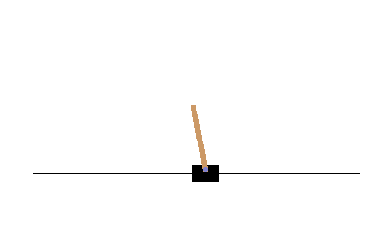

In [20]:
# Testing the agent - run this smaller sampling after the agent is achieving success and NOT exploring

num_episodes = 5
max_length = 200
initial_reward = 1
steps = learner(agent=q_agent, episodes=num_episodes, max_length = max_length,
            init_reward=initial_reward, mode='test') # set mode to 'test' to avoid exploration

In [21]:
print("Minimum step count in {} episodes: {}".format(num_episodes, np.min(steps)))
print("Average step count in {} episodes: {}".format(num_episodes, np.mean(steps)))
print("Maximum step count in {} episodes: {}".format(num_episodes, np.max(steps)))
print("Q-table size: ", q_agent.q_table.size)
print("Q-table nonzero count: ", np.count_nonzero(q_agent.q_table))

Minimum step count in 5 episodes: 15.0
Average step count in 5 episodes: 21.0
Maximum step count in 5 episodes: 32.0
Q-table size:  20000
Q-table nonzero count:  108


# 6. Example: MountainCar-v0 <a name='mtn' />

OpenAI Gym is full of environments to try with varying difficulties and challenges.  Start by reviewing the information found in the [wiki](https://github.com/openai/gym/wiki/Table-of-environments).  Here's some information provided about the [MountainCar-v0 environment](https://github.com/openai/gym/wiki/MountainCar-v0):

<img src="image/mtncar.png?" width="450">

#### Description
Get an under powered car to the top of a hill (top = 0.5 position).

#### Observation
Type: Box(2)

Num | Observation | Min | Max
---|---|---|---
0 | Position | -1.2 | 0.6
1 | Velocity | -0.07 | 0.07

#### Actions
Type: Discrete(3)

Num | Action
--- | ---
0 | push left
1 | no push
2 | push right

#### Reward
-1 for each time step, until the goal position of 0.5 is reached. As with MountainCarContinuous v0, there is no penalty for climbing the left hill, which upon reached acts as a wall.

#### Starting state
Random position from -0.6 to -0.4 with no velocity.

#### Episode termination
The episode ends when you reach 0.5 position, or if 200 iterations are reached.




### Execution: MountainCar with the Random agent

KeyboardInterrupt: 

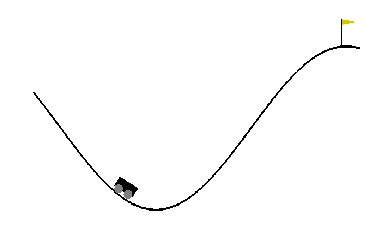

In [22]:
# try mountain car with the Random agent (default)
steps = learner(env_id='MountainCar-v0', episodes=3, max_length = 200, init_reward=0)

### Preparation: MountainCar with the Q-Learning agent

Before running the Q-Learning agent, we need to consider how the environment setup will affect the learning for our agent.  The MountainCar-v0 problem is a hard one because the agent can't really learn what actions are helpful until it actually climbs the hill successfully.  As long as that goal has not been met, all the episodes will have an accumulated reward of -1 for each timestep, or -200, since the number of steps allowed is capped.  Therefore, it's important that the car explores as many avenues as possible to solve the problem.  As a help for this notebook, we can extend the number of timesteps for the learner by ignoring the "done" signal and setting a higher number for the `max_length` parameter in learner. A special case provision has been included in the learner for this operation specifically for MountainCar-v0

The Q-Learning agent also needs a way to discretize the observations for MountainCar, just as it did for the CartPole problem.  Although the agent itself will use the same basic iterative algorithm, we need to change the setup a bit.  This can be accomplished by setting up a different table of "splits".

Whereas in CartPole, the split was:
``` python

    splits = [
    # Position
    np.linspace(-2.4, 2.4, n_bins)[1:-1],
    # Velocity
    np.linspace(-3.5, 3.5, n_bins)[1:-1],
    # Angle.
    np.linspace(-0.5, 0.5, n_bins)[1:-1],
    # Tip velocity
    np.linspace(-2.0, 2.0, n_bins)[1:-1]
    ]
 ```
 
MountainCar only has two observation values:
``` python
    splits = [
    # Position
    np.linspace(-1.2, 0.6, n_bins)[1:-1],
    # Velocity
    np.linspace(-0.07, 0.07, n_bins)[1:-1],
    ]
```
In addition, the MountainCar problem has three actions whereas the CarPole only had two, so the agent will need to knw that . The Q-Learning agent defined previously has a provision for passing all the parameters it uses including the number of actions and splits.  Go ahead and create a split table now for the MountainCar Q-Learning agent and define the agent.

In [ ]:
# TODO define the number of bins `n_bins` and a list name `splits_mtncar` for use by the Q-Learning agent.
# The n_bins used for CartPole was 9, but feel free to experiment with this number
# n_bins = 
# splits_mtncar = 


# ANSWER
n_bins = 20
splits_mtncar = [
    # Position
    np.linspace(-1.2, 0.6, n_bins)[1:-1],
    # Velocity
    np.linspace(-0.07, 0.07, n_bins)[1:-1],
    ]

In [ ]:
# TODO instantiate a QLearningAgent named q_agent_mtncar
# you may want to tweak the hyper-parameters, such as the exploration rate, to increase
#    the agent's chances of climbing the hill
# q_agent_mtncar = 


# ANSWER
q_agent_mtncar = QLearningAgent(learning_rate = 0.2, discount_factor = 0.9,
                                exploration_rate = 0.8,
                                n_actions = 3, n_bins = n_bins, splits = splits_mtncar)

In [ ]:
# Run the agent long enough for it to achieve success within 500 steps
# Feel free to modify any of these parameters
num_episodes = 50
max_length = 2000
steps = learner(agent=q_agent_mtncar, env_id='MountainCar-v0',
                        episodes=num_episodes, max_length = max_length, init_reward=0,
                        ignore_done=True, visualize_plt=False)

In [ ]:
print("Minimum step count in {} episodes: {}".format(num_episodes, np.min(steps)))
print("Average step count in {} episodes: {}".format(num_episodes, np.mean(steps)))
print("Maximum step count in {} episodes: {}".format(num_episodes, np.max(steps)))
print("Q-table size: ", q_agent_mtncar.q_table.size)
print("Q-table nonzero count: ", np.count_nonzero(q_agent_mtncar.q_table))

### Execution: Test the trained agent

In [ ]:
# Testing the agent - run this smaller sampling after the agent is achieving success
num_episodes = 3
max_length = 500
steps = learner(agent=q_agent_mtncar, env_id='MountainCar-v0',
                        episodes=num_episodes, max_length = max_length, init_reward=0,
                        ignore_done=True, visualize_plt=True, mode='test')

In [ ]:
print("Minimum step count in {} episodes: {}".format(num_episodes, np.min(steps)))
print("Average step count in {} episodes: {}".format(num_episodes, np.mean(steps)))
print("Maximum step count in {} episodes: {}".format(num_episodes, np.max(steps)))
print("Q-table size: ", q_agent_mtncar.q_table.size)
print("Q-table nonzero count: ", np.count_nonzero(q_agent_mtncar.q_table))

# Congratulations!  
Now you are on your way to trying other environment problems and RL algorithms.  Feel free to add additional cells here in order to try additional environments in OpenAI Gym.